# CNN-Transformers Encoder Decoder
We used this Tensorflow tutorial utilizing Multiheaded Attention for reference: [Image Captioning](https://www.tensorflow.org/tutorials/text/image_captioning)

## Import Statements

In [ ]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
from tqdm import tqdm

import tensorflow as tf

2022-12-18 22:27:09.440301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 22:27:10.620624: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-18 22:27:10.620777: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from glob import glob

In [ ]:
ROOT_DIR = '/home/sushie/'
# ROOT_DIR = '/content/drive/MyDrive/Coursework/Fall \'22/NNDL/Project/NNDL Project/'
DATA_DIR = ROOT_DIR + 'data/data_split/train/superclass'
TEST_DATA_DIR = ROOT_DIR + 'data/data_split/test'
MODEL_DIR = ROOT_DIR + 'models/cnn_transformer_attention/'

In [ ]:
batch_size = 64
img_size = (100, 100)

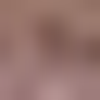

In [ ]:
sample_image = keras.preprocessing.image.load_img(
    glob(DATA_DIR+'/*/*.jpg')[0], grayscale=False, color_mode="rgb", target_size=img_size, interpolation="bicubic"
)
sample_image

# Load and preprocess data

In [ ]:
input_shape = keras.preprocessing.image.img_to_array(sample_image).shape
input_shape

(100, 100, 3)

In [ ]:
superclass_idx_to_name_map = pd.read_csv(ROOT_DIR + 'Released_Data/super_classes_mapping.csv')
superclass_idx_to_name_map = {k:v for k,v in superclass_idx_to_name_map.values}

subclass_idx_to_name_map = pd.read_csv(ROOT_DIR + 'Released_Data/sub_classes_mapping.csv')
subclass_idx_to_name_map = {k:v for k,v in subclass_idx_to_name_map.values}

sub_to_superclass_idx_map = pd.read_csv(ROOT_DIR + 'Released_Data/train_data.csv')
sub_to_superclass_idx_map = {k:v for k, v in zip(sub_to_superclass_idx_map.subclass_index.values, 
                                                 sub_to_superclass_idx_map.superclass_index.values)}

idx_to_vocab_input_map = superclass_idx_to_name_map.copy()
idx_to_vocab_input_map[3] = '[START]'
vocab_input_to_idx_map = {v:k for k,v in idx_to_vocab_input_map.items()}
idx_to_vocab_input_map, vocab_input_to_idx_map

({0: 'bird', 1: 'dog', 2: 'reptile', 3: '[START]'},
 {'bird': 0, 'dog': 1, 'reptile': 2, '[START]': 3})

In [ ]:
def get_dataloaders(batch_size, validation_split, image_size, interpolation, seed):
    # Load train data
    labels_df = pd.read_csv(ROOT_DIR+'Released_Data/train_data.csv')
    file_paths = {file_path.rsplit('/')[-1]: file_path for file_path in glob(DATA_DIR + f'/*/*.jpg')}
    labels_df = labels_df[labels_df.image.isin(file_paths.keys())]
    images = [np.array(keras.preprocessing.image.load_img(file_paths[i], color_mode='rgb', 
                                                 grayscale=False,
                                                 target_size=image_size, 
                                                 interpolation=interpolation)).astype('float32') 
        for i in tqdm(labels_df.image.values, desc='Loading images')]
    labels_superclass = labels_df.superclass_index.astype(int).values.tolist()
    labels_subclass = labels_df.subclass_index.astype(int).values.tolist()
    labels = list(zip(labels_superclass, labels_subclass))

    images = np.array(images)
    labels = np.array(labels)
    sequences = np.stack([np.ones_like(labels_superclass)*vocab_input_to_idx_map['[START]'], labels_superclass], axis=1)

    # Split train and val
    images_train, images_val, sequences_train, \
        sequences_val, labels_train, labels_val = train_test_split(images, sequences, labels, 
                                                                   test_size=validation_split, random_state=seed, 
                                                                   stratify=labels_subclass)
    # Load test data
    truth_df = pd.read_csv(TEST_DATA_DIR+'/Truth.csv')
    file_paths = {file_path.rsplit('/')[-1]: file_path for file_path in glob(TEST_DATA_DIR + f'/*.jpg')}
    images = [np.array(keras.preprocessing.image.load_img(file_paths[i], color_mode='rgb', 
                                                 grayscale=False,
                                                 target_size=image_size, 
                                                 interpolation=interpolation)).astype('float32') 
        for i in tqdm(truth_df.image.values, desc='Loading test images')]
    labels_superclass = truth_df.superclass_index.astype(int).values.tolist()
    labels_subclass = truth_df.subclass_index.astype(int).values.tolist()
    labels = list(zip(labels_superclass, labels_subclass))

    images_test = np.array(images)
    labels_test = np.array(labels)
    sequences_test = np.stack([np.ones_like(labels_superclass)*vocab_input_to_idx_map['[START]'], labels_superclass], axis=1)
    
    print()
    print(f"Training samples: {len(images_train)}")
    print(f"Validation samples: {len(images_val)}")
    print(f"Testing samples: {len(images_test)}")

    train_ds = tf.data.Dataset.from_tensor_slices(((images_train, sequences_train), 
                                                   (labels_train[:, 0].reshape(-1, 1), labels_train[:, 1].reshape(-1, 1)))).shuffle(buffer_size=1024).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices(((images_val, sequences_val[:, 0].reshape(-1, 1)), 
                                                 (labels_val[:, 0].reshape(-1, 1), labels_val[:, 1].reshape(-1, 1)))).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(((images_test, sequences_test[:, 0].reshape(-1, 1)), 
                                                  (labels_test[:, 0].reshape(-1, 1), labels_test[:, 1].reshape(-1, 1)))).batch(batch_size)
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataloaders(batch_size=batch_size, validation_split=.2, 
                                            image_size=img_size, interpolation='bicubic', 
                                            seed=42)

Loading test images: 100%|████████████████████████| 1942/1942 [00:01<00:00, 1151.30it/s]
2022-12-18 22:27:21.523721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero



Training samples: 3624
Validation samples: 906
Testing samples: 1942


2022-12-18 22:27:21.637164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 22:27:21.638017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 22:27:21.644587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 22:27:21.646042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 1), dtype=tf.int64, name=None),
  TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)))

In [ ]:
val_ds.element_spec

((TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 1), dtype=tf.int64, name=None),
  TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)))

In [ ]:
test_ds.element_spec

((TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 1), dtype=tf.int64, name=None),
  TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)))

## CNN Encoder

In [ ]:
convnet = keras.Sequential([
            keras.applications.MobileNetV3Small(
                include_top=False,
                include_preprocessing=True,
                input_shape=input_shape,),
        ], name='convnet')
convnet.trainable = False

## Transformer Decoder

### Input

In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, max_length, depth):
        super().__init__()
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

        self.token_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=depth,
            mask_zero=True)
        
        self.add = tf.keras.layers.Add()

    def call(self, seq):
        seq = self.token_embedding(seq)

        x = tf.range(tf.shape(seq)[1])
        x = x[tf.newaxis, :]
        x = self.pos_embedding(x)

        return self.add([seq,x])

### Decoder

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add() 
        self.layernorm = tf.keras.layers.LayerNormalization()
    
    def call(self, x):
        attn = self.mha(query=x, value=x,
                        use_causal_mask=True)
        x = self.add([x, attn])
        return self.layernorm(x)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add() 
        self.layernorm = tf.keras.layers.LayerNormalization()
    
    def call(self, x, y, **kwargs):
        attn, attention_scores = self.mha(
                query=x, value=y,
                return_attention_scores=True)
        
        self.last_attention_scores = attention_scores

        x = self.add([x, attn])
        return self.layernorm(x)

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, units, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(units=2*units, activation='relu'),
            tf.keras.layers.Dense(units=units),
            tf.keras.layers.Dropout(rate=dropout_rate),
        ])

        self.layernorm = tf.keras.layers.LayerNormalization()
    
    def call(self, x):
        x = x + self.seq(x)
        return self.layernorm(x)


In [ ]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=1, dropout_rate=0.1):
        super().__init__()
        
        self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                                key_dim=units,
                                                dropout=dropout_rate)
        self.cross_attention = CrossAttention(num_heads=num_heads,
                                            key_dim=units,
                                            dropout=dropout_rate)
        self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
        

    def call(self, inputs, training=False):
        in_seq, out_seq = inputs

        out_seq = self.self_attention(out_seq)

        out_seq = self.cross_attention(out_seq, in_seq)
        
        self.last_attention_scores = self.cross_attention.last_attention_scores

        out_seq = self.ff(out_seq)

        return out_seq

In [ ]:
class HierarchicalImageClassifier(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, feature_extractor, num_superclasses, num_subclasses, text_input_size,
                num_decoder_layers=1, units=256, max_length=2, num_heads=1, dropout_rate=0.1):
        super().__init__()
        self.feature_extractor = feature_extractor

        self.seq_embedding = SeqEmbedding(
            vocab_size=text_input_size,
            depth=units,
            max_length=max_length)

        self.decoder_layers = [
            TransformerDecoder(units, num_heads=num_heads, dropout_rate=dropout_rate)
            for n in range(num_decoder_layers)]

        self.cls_super = layers.Dense(units=num_superclasses)
        self.cls_sub = layers.Dense(units=num_subclasses)

In [ ]:
@HierarchicalImageClassifier.add_method
def call(self, inputs, training=False):
    image, sequence = inputs

    if image.shape[-1] == 3:
        # Apply the feature-extractor, if you get an RGB image.
        # image = image/255.
        image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')

    embedding = self.seq_embedding(sequence)


    # Look at the image
    if training:
        for dec_layer in self.decoder_layers:
            embedding = dec_layer(inputs=(image, embedding))
        output_super = self.cls_super(embedding[:, 0, :])
        output_sub = self.cls_sub(embedding[:, 1, :])
    else:
        for dec_layer in self.decoder_layers:
            embedding = dec_layer(inputs=(image, embedding))
        output_super = self.cls_super(embedding[:, 0, :])
        
        pred_super = tf.reshape(tf.argmax(output_super, axis=1), (-1, 1))
        sequence = tf.concat([sequence, pred_super], axis=1)
        embedding = self.seq_embedding(sequence)
        for dec_layer in self.decoder_layers:
            embedding = dec_layer(inputs=(image, embedding))
        output_sub = self.cls_sub(embedding[:, 1, :])

    return output_super, output_sub

In [ ]:
@HierarchicalImageClassifier.add_method
def predict_single(self, image):
    sequence = tf.constant(vocab_input_to_idx_map['[START]'], shape=(1, 1), dtype='int64')
    img_features = self.feature_extractor(image[tf.newaxis, ...])

    output_super, output_sub = self((img_features, sequence), training=False)
    pred_super = tf.argmax(output_super, axis=1).numpy()[0]
    pred_sub = tf.argmax(output_sub, axis=1).numpy()[0]
    result = [superclass_idx_to_name_map[pred_super], subclass_idx_to_name_map[pred_sub]]
    return result

## Train

In [ ]:
model = HierarchicalImageClassifier(feature_extractor=convnet, 
                                    num_superclasses=len(superclass_idx_to_name_map.keys()),
                                    num_subclasses=len(subclass_idx_to_name_map.keys()),
                                    text_input_size=len(idx_to_vocab_input_map.keys()),
                                    num_decoder_layers=2, units=256, 
                                    max_length=2, num_heads=2, dropout_rate=0.3,)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_object = [keras.losses.SparseCategoricalCrossentropy(from_logits=True), keras.losses.SparseCategoricalCrossentropy(from_logits=True)]
loss_weight =  [1, .5]

model.compile(optimizer=optimizer,
              loss=loss_object,
              loss_weights=loss_weight,
              metrics='accuracy')

In [ ]:
num_epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,)

Epoch 1/10


2022-12-18 22:27:39.908429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2022-12-18 22:27:43.028800: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f42294396c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-18 22:27:43.028850: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2022-12-18 22:27:43.089281: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-18 22:27:43.630526: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 [==============================] - 28s 110ms/step - loss: 3.1168 - output_1_loss: 0.9688 - output_2_loss: 4.2960 - output_1_accuracy: 0.5549 - output_2_accuracy: 0.0381 - val_loss: 2.8306 - val_output_1_loss: 0.6906 - val_output_2_loss: 4.2800 - val_output_1_accuracy: 0.7119 - val_output_2_accuracy: 0.0673
Epoch 2/10
57/57 [==============================] - 3s 52ms/step - loss: 2.5578 - output_1_loss: 0.7323 - output_2_loss: 3.6510 - output_1_accuracy: 0.6772 - output_2_accuracy: 0.0701 - val_loss: 2.7845 - val_output_1_loss: 0.6514 - val_output_2_loss: 4.2661 - val_output_1_accuracy: 0.7196 - val_output_2_accuracy: 0.0762
Epoch 3/10
57/57 [==============================] - 3s 54ms/step - loss: 2.3685 - output_1_loss: 0.6627 - output_2_loss: 3.4116 - output_1_accuracy: 0.7196 - output_2_accuracy: 0.1013 - val_loss: 2.6603 - val_output_1_loss: 0.5999 - val_output_2_loss: 4.1207 - val_output_1_accuracy: 0.7561 - val_output_2_accuracy: 0.1015
Epoch 4/10
57/57 [======================

### Fine tune

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_object = [keras.losses.SparseCategoricalCrossentropy(from_logits=True), keras.losses.SparseCategoricalCrossentropy(from_logits=True)]
loss_weight =  [1, .5]

model.compile(optimizer=optimizer,
              loss=loss_object,
              loss_weights=loss_weight,
              metrics='accuracy')

In [ ]:
num_epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,)

Epoch 1/10
57/57 [==============================] - 20s 97ms/step - loss: 1.6602 - output_1_loss: 0.4399 - output_2_loss: 2.4407 - output_1_accuracy: 0.8154 - output_2_accuracy: 0.3267 - val_loss: 2.5708 - val_output_1_loss: 0.6088 - val_output_2_loss: 3.9239 - val_output_1_accuracy: 0.7759 - val_output_2_accuracy: 0.1711
Epoch 2/10
57/57 [==============================] - 3s 52ms/step - loss: 1.6372 - output_1_loss: 0.4395 - output_2_loss: 2.3955 - output_1_accuracy: 0.8226 - output_2_accuracy: 0.3380 - val_loss: 2.5795 - val_output_1_loss: 0.6086 - val_output_2_loss: 3.9419 - val_output_1_accuracy: 0.7704 - val_output_2_accuracy: 0.1744
Epoch 3/10
57/57 [==============================] - 3s 51ms/step - loss: 1.6232 - output_1_loss: 0.4437 - output_2_loss: 2.3590 - output_1_accuracy: 0.8212 - output_2_accuracy: 0.3435 - val_loss: 2.5975 - val_output_1_loss: 0.6138 - val_output_2_loss: 3.9674 - val_output_1_accuracy: 0.7649 - val_output_2_accuracy: 0.1689
Epoch 4/10
57/57 [============

## Evaluate on Test Set

In [ ]:
model.evaluate(test_ds)

31/31 [==============================] - 2s 47ms/step - loss: 2.6715 - output_1_loss: 0.6457 - output_2_loss: 4.0517 - output_1_accuracy: 0.7611 - output_2_accuracy: 0.1406


[2.6715192794799805,
 0.6456513404846191,
 4.0517354011535645,
 0.7610710859298706,
 0.14057672023773193]

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [ ]:
pd.read_csv(TEST_DATA_DIR + '/Truth.csv')

,image,superclass_index,subclass_index
0,2095.jpg,2,62
1,4404.jpg,0,85
2,6205.jpg,1,10
3,351.jpg,0,24
4,5655.jpg,2,62
...,...,...,...
1937,6077.jpg,1,31
1938,3639.jpg,0,27
1939,5180.jpg,2,47
1940,5923.jpg,1,21


In [ ]:
subclass_idx_to_name_map[0]

'Scotch terrier, Scottish terrier, Scottie'

In [ ]:
def load_image(file_name):
    return tf.keras.preprocessing.image.load_img(TEST_DATA_DIR + f'/{file_name}', target_size=img_size, interpolation='bicubic')

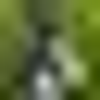

In [ ]:
image = load_image('4949.jpg')
image

In [ ]:
from textwrap import wrap

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(8, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title("\n".join(wrap(str_tokens[i], 30))))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.4, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

In [ ]:
@HierarchicalImageClassifier.add_method
def run_and_show_attention(self, image):
  result = self.predict_single(np.array(image))

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=4, width=4,
      reduction='mean')
  
  plot_attention_maps(np.array(image)/255., result, attention_maps)


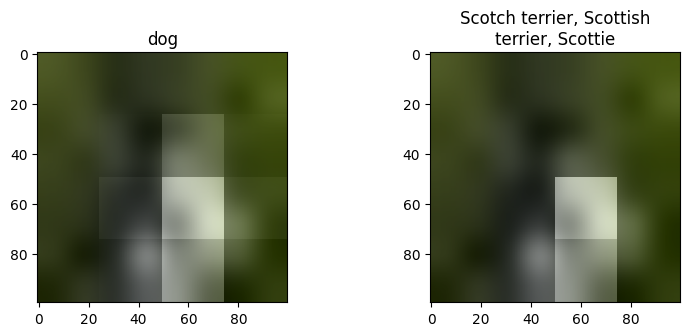

In [ ]:
run_and_show_attention(model, image)

## Modelshare AI

In [ ]:
def get_test_dataloader(batch_size, image_size, interpolation):
    # Load train data
    file_paths = [(ROOT_DIR+'test_shuffle/' + str(i) + '.jpg') for i in range(0, 9127)]
    images = [np.array(keras.preprocessing.image.load_img(i, color_mode='rgb', 
                                                 grayscale=False,
                                                 target_size=image_size, 
                                                 interpolation=interpolation)).astype('float32') 
        for i in tqdm(file_paths, desc='Loading images')]

    images = np.array(images)
    sequences = np.stack([np.ones(images.shape[0])*vocab_input_to_idx_map['[START]'], np.ones(images.shape[0])*-1], axis=1).astype('int64')
    labels = np.ones(images.shape[0])*-1

    print()
    print(f"Testing samples: {len(images)}")

    test_ds = tf.data.Dataset.from_tensor_slices(((images, sequences[:, 0].reshape(-1,1)), (labels, labels))).batch(batch_size)
    return test_ds

In [ ]:
modelshare_test_ds = get_test_dataloader(batch_size, img_size, 'bicubic')

Loading images: 100%|█████████████████████████████| 9127/9127 [00:03<00:00, 2458.51it/s]



Testing samples: 9127


In [ ]:
logits_superclass, logits_subclass = model.predict(modelshare_test_ds)

143/143 [==============================] - 10s 47ms/step


In [ ]:
probas_super = tf.nn.softmax(logits_superclass, axis=1)
probas_sub = tf.nn.softmax(logits_subclass, axis=1)

In [ ]:
super_predictions_df = pd.DataFrame({'predictions': np.argmax(probas_super, axis=1).tolist()})
super_predictions_df.predictions = super_predictions_df.predictions.map(superclass_idx_to_name_map)
super_predictions_df

,predictions
0,dog
1,dog
2,reptile
3,reptile
4,bird
...,...
9122,dog
9123,dog
9124,dog
9125,dog


In [ ]:
sub_predictions_df = pd.DataFrame({'predictions': np.argmax(probas_sub, axis=1).tolist()})
sub_predictions_df

,predictions
0,22
1,65
2,58
3,29
4,6
...,...
9122,0
9123,31
9124,38
9125,65


In [ ]:
sub_predictions_df.loc[np.max(probas_sub.numpy(), axis=1) <=.6, 'predictions'] = 89

In [ ]:
sub_predictions_df.predictions = sub_predictions_df.predictions.map(subclass_idx_to_name_map)

In [ ]:
sub_predictions_df

,predictions
0,novel
1,novel
2,novel
3,novel
4,ptarmigan
...,...
9122,novel
9123,novel
9124,novel
9125,novel


In [ ]:
super_predictions_df.to_csv('superclass_predictions.csv', index=False)

In [ ]:
sub_predictions_df.to_csv('subclass_predictions.csv', index=False)